In [1]:
### Import pandas modules and packages and load in the main dataframe ###
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col
import random
from unidecode import unidecode
import gc 

app = pd.read_csv(r'C:\Users\sambo\Desktop\615\application_data.csv', usecols=['application_number','filing_date','patent_issue_date'], dtype=str) 

inv = pd.read_csv(r'C:\Users\sambo\Desktop\615\all_inventors.csv', usecols=['application_number','inventor_name_first','inventor_name_middle', 'inventor_name_last', 'inventor_region_code'], dtype =str)

#  Both datasets are available here https://bulkdata.uspto.gov/data/patent/pair/economics/2019/

In [2]:
# Create a single column for inventors
inv['inventor'] = inv['inventor_name_first'] + inv['inventor_name_middle'] + inv['inventor_name_last']

In [3]:
def standardize(ser):
    #Standardize the company name string to the most basic format
    ser = ser.apply(unidecode)
    ser = ser.str.lower()
    ser = ser.str.replace('&','and')
    ser = ser.str.replace(',',' ')
    ser = ser.str.replace('.',' ')
    ser = ser.str.replace('[^0-9a-zA-Z .]','')
    ser = ser.str.replace(' {2,}',' ')
    ser = ser.str.strip()

    return ser

In [4]:
inv['inventor'] = inv['inventor'].astype(str)


In [5]:
inv['inventor'] = standardize(inv['inventor'])

In [6]:
# Merge the inventor name on to the application data
df = inv.merge(app, how='left', on='application_number')

In [7]:
# Delete the extra columns 
del df['inventor_name_first']
del df['inventor_name_middle']
del df['inventor_name_last']

In [8]:
# Drop any rows that do not contain the inventor region code. For americans the inventor region code is the state. 
df.dropna(subset=['inventor_region_code'] ,inplace=True)

In [9]:
# Create a variable that contains only the year the application was filed. Commented out is the same procedure for patent issue date/year.
df.sort_values(by='filing_date', inplace=True, ignore_index=True)
df['filing_year'] = df['filing_date'].str[:4]
df.dropna(subset=['filing_year'] ,inplace=True)
df['filing_year'] = df['filing_year'].astype(int)
df['issue_year'] = df['patent_issue_date'].str[:4]


In [10]:
# only keep patents that were filed on or after January 1 2008
df = df[(df['filing_year'] >= 2008)]

In [11]:
# Create a dataframe for each state that will be a part of the analysis.
ny = df[df['inventor_region_code'].str.contains("NY")]
ny = ny[ny.inventor_region_code != 'NYK']
tx = df[df['inventor_region_code'].str.contains("TX")]



In [12]:
# Removing unnecessary dataframes
del df
del app
del inv

In [13]:
# Count the the total number of applications filed by all inventors in both states for each year.
ny_year_count = ny.groupby(['filing_year', 'inventor_region_code'], as_index=False).agg({'application_number': 'count'})
tx_year_count = tx.groupby(['filing_year', 'inventor_region_code'], as_index= False).agg({'application_number': 'count'})

In [14]:
# Count the number of applications filed by each inventor in both states for each year.
ny_year_inv_count = ny.groupby(['inventor','filing_year'], as_index=False).agg({'application_number': 'count'})
tx_year_inv_count = tx.groupby(['inventor','filing_year'], as_index= False).agg({'application_number': 'count'})

In [15]:
ny

,application_number,inventor_region_code,inventor,filing_date,patent_issue_date,filing_year,issue_year
7421610,11994411,NY,nan,2008-01-01,2013-11-26,2008,2013
7421658,61009787,NY,johnh fitzgerald,2008-01-02,NaN,2008,NaN
7421660,61009787,NY,dalec furman,2008-01-02,NaN,2008,NaN
7421699,61018580,NY,nan,2008-01-02,NaN,2008,NaN
7421703,PCT/US08/50004,NY,nan,2008-01-02,NaN,2008,NaN
...,...,...,...,...,...,...,...
15972077,16756692,NY,seanmatthewgarner,2020-04-16,NaN,2020,NaN
15972078,16756692,NY,jenchieh lin,2020-04-16,NaN,2020,NaN
15972095,16756692,NY,jiangwei feng,2020-04-16,NaN,2020,NaN
15972168,16758384,NY,brianjoshuaberman,2020-04-22,NaN,2020,NaN


In [16]:
# Ensuring that every inventor has an entry for every year even if they did not file any patent applications in that year.
mux_tx = pd.MultiIndex.from_product([
        tx.inventor.unique(),
        range(tx.filing_year.min(), tx.filing_year.max() + 1)
    ], names=['inventor', 'filing_year'])
mux_ny = pd.MultiIndex.from_product([
        ny.inventor.unique(),
        range(ny.filing_year.min(), ny.filing_year.max() + 1)
    ], names=['inventor', 'filing_year'])

ny.drop_duplicates(subset=['inventor', 'filing_year'], inplace=True) 
tx.drop_duplicates(subset=['inventor', 'filing_year'], inplace=True)

ny = ny.set_index(['inventor', 'filing_year']).reindex(mux_ny).reset_index()
tx = tx.set_index(['inventor', 'filing_year']).reindex(mux_tx).reset_index()

In [17]:
ny

,inventor,filing_year,application_number,inventor_region_code,filing_date,patent_issue_date,issue_year
0,nan,2008,11994411,NY,2008-01-01,2013-11-26,2013
1,nan,2009,61142207,NY,2009-01-01,NaN,NaN
2,nan,2010,12651470,NY,2010-01-03,2013-11-19,2013
3,nan,2011,61429137,NY,2011-01-01,NaN,NaN
4,nan,2012,13342128,NY,2012-01-02,2015-04-07,2015
...,...,...,...,...,...,...,...
730244,lu zhang,2016,NaN,NaN,NaN,NaN,NaN
730245,lu zhang,2017,NaN,NaN,NaN,NaN,NaN
730246,lu zhang,2018,NaN,NaN,NaN,NaN,NaN
730247,lu zhang,2019,NaN,NaN,NaN,NaN,NaN


In [18]:
# Merge in counts, rename volumns, and fill in the missing data
ny = ny.merge(ny_year_inv_count, on=['inventor','filing_year'], how='left')
tx = tx.merge(tx_year_inv_count, on=['inventor','filing_year'], how='left')
ny = ny.merge(ny_year_count, on='filing_year', how='left')
tx = tx.merge(tx_year_count, on='filing_year', how='left')



In [19]:
ny['state_application_count'] = ny['application_number']
tx['state_application_count'] = tx['application_number']
ny['inv_application_count'] = ny['application_number_y']
tx['inv_application_count'] = tx['application_number_y']
ny['inventor_region_code'] = ny['inventor_region_code_y']
tx['inventor_region_code'] = tx['inventor_region_code_y']

In [20]:
ny = ny[[ 'inventor', 'filing_date', 'patent_issue_date', 'inventor_region_code' ,'filing_year' , 'issue_year', 'state_application_count','inv_application_count']]
tx = tx[[ 'inventor', 'filing_date', 'patent_issue_date', 'inventor_region_code' ,'filing_year' , 'issue_year', 'state_application_count','inv_application_count']]

In [21]:
ny['inv_application_count'] =ny['inv_application_count'].fillna(0)
tx['inv_application_count'] =tx['inv_application_count'].fillna(0)

In [22]:
# Removing inventors that do not contain a real entry
ny = ny[ny.inventor != 'nan']
tx = tx[tx.inventor != 'nan']

In [23]:
# Creating our dependent variable. This variable is called 'inv_app' change and it looks at the difference in the number of patent applications filed between the current period and the previous period. This tells us if an inventor is producing more, less, or the same amount of patent applications as they did in the previous period. 
ny = ny.sort_values(['inventor', 'filing_year']).reset_index(drop=True)
ny['inv_appchg'] = ny.groupby('inventor', sort=False)['inv_application_count'].apply(
     lambda x: x.diff()).to_numpy()
tx = tx.sort_values(['inventor', 'filing_year']).reset_index(drop=True)
tx['inv_appchg'] = tx.groupby('inventor', sort=False)['inv_application_count'].apply(
     lambda x: x.diff()).to_numpy()

In [24]:
# Creating a dependent variable that is the percent change in inventors filing patents in New York or Texas for each year.
ny_years = ny.drop_duplicates(subset='filing_year') 
tx_years = tx.drop_duplicates(subset='filing_year') 
ny_years['state_appchg'] = ny_years['state_application_count'].pct_change()
tx_years['state_appchg'] = tx_years['state_application_count'].pct_change()
ny_years = ny_years[['state_appchg', 'filing_year']]
tx_years = tx_years[['state_appchg', 'filing_year']]

<AxesSubplot:xlabel='filing_year'>

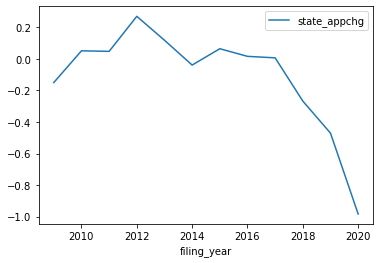

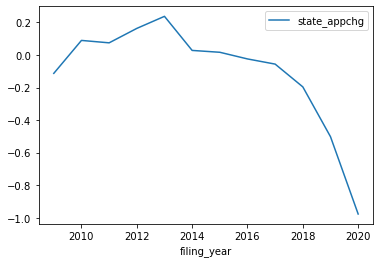

In [25]:
# Graphing the percent change in inventors filing patents in New York or Texas for each year.
ny_years.plot('filing_year','state_appchg')
tx_years.plot('filing_year','state_appchg')

In [26]:
# Merging the state application change variable on to the state dataframes.
ny = ny.merge(ny_years, how='left', on='filing_year')
tx = tx.merge(tx_years, how='left', on='filing_year')

In [27]:
# Preparing the data for dummy variables
ny_0 = ny[(ny['filing_year'] > 2008) & (ny['filing_year'] < 2014)]
ny_1 = ny[(ny['filing_year'] >= 2014) & (ny['filing_year'] < 2020)]
tx_0 = tx[(tx['filing_year'] > 2008) & (tx['filing_year'] < 2014)]
tx_1 = tx[(tx['filing_year'] >= 2014) & (tx['filing_year'] < 2020)]

In [28]:
ny_0['T'] = 0
ny_1['T'] = 1
tx_0['T'] = 0
tx_1['T'] = 0
ny_0['time'] = 0
ny_1['time'] = 1
tx_0['time'] = 0
tx_1['time'] = 1
ny_0['group'] = 1
ny_1['group'] = 1
tx_0['group'] = 0
tx_1['group'] = 0

In [29]:
good_ny= pd.concat([ny_0, ny_1])
good_tx= pd.concat([tx_0, tx_1])

In [30]:
# Adding in the population data for both states for each year to the state datframes. 
pop = pd.read_excel(r'C:\Users\sambo\Desktop\615\nytxdid.xls', sheet_name='Annual')
pop['filing_year'] = pop['DATE'].astype(str).str[:4]
pop['filing_year'] = pop['filing_year'].astype(int)
pop['ny_pop'] = pop['NYPOP']* 1000
pop['tx_pop'] = pop['TXPOP']* 1000 
del pop['NYPOP']
del pop['TXPOP']
del pop['DATE']

In [31]:
good_ny = pd.merge(good_ny, pop, how='left', on = 'filing_year')
good_tx = pd.merge(good_tx, pop, how='left', on = 'filing_year')

In [32]:
good_ny['pop'] = good_ny['ny_pop'] 
good_tx['pop'] = good_tx['tx_pop'] 
del good_ny['ny_pop'] 
del good_ny['tx_pop'] 
del good_tx['tx_pop'] 
del good_tx['ny_pop'] 

In [33]:
# The data is now prepared for analysis. This line can always be run to reset the data. 
good_data = pd.concat([good_ny, good_tx])

In [34]:
good_data

,inventor,filing_date,patent_issue_date,inventor_region_code,filing_year,issue_year,state_application_count,inv_application_count,inv_appchg,state_appchg,T,time,group,pop
0,0 j ge,NaN,NaN,NY,2009,NaN,32081,0.0,0.0,-0.149992,0,0,1,19307066.0
1,0 j ge,NaN,NaN,NY,2010,NaN,33723,0.0,0.0,0.051183,0,0,1,19399878.0
2,0 j ge,NaN,NaN,NY,2011,NaN,35331,0.0,0.0,0.047683,0,0,1,19499241.0
3,0 j ge,NaN,NaN,NY,2012,NaN,44866,0.0,0.0,0.269876,0,0,1,19572932.0
4,0 j ge,NaN,NaN,NY,2013,NaN,50177,0.0,0.0,0.118375,0,0,1,19624447.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
841253,zygmuntj haas,2015-05-20,2017-08-15,TX,2015,2017,58171,2.0,1.0,0.016567,0,1,0,27470056.0
841254,zygmuntj haas,NaN,NaN,TX,2016,NaN,56756,0.0,-2.0,-0.024325,0,1,0,27914410.0
841255,zygmuntj haas,NaN,NaN,TX,2017,NaN,53573,0.0,0.0,-0.056082,0,1,0,28295273.0
841256,zygmuntj haas,NaN,NaN,TX,2018,NaN,43077,0.0,0.0,-0.195920,0,1,0,28628666.0


In [35]:
# Preparing the data for analysis of the effects on the state. 
good_data.drop_duplicates(subset=['filing_year','inventor_region_code','state_appchg'], inplace=True)

In [36]:
# Creating a dummy variable for each year 
yeardummy = pd.get_dummies(good_data['filing_year'])
good_data= pd.concat([good_data, yeardummy], axis=1)

In [37]:
# setting the dependent and independent variables for analysis. 
good_data['y'] = good_data['state_appchg']
y = good_data['y']
X = good_data[['T','group','pop',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]
X = sm.add_constant(X)


In [38]:
model = sm.OLS(y, X)
results1 = model.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.972
Model:                            OLS   Adj. R-squared:                  0.927
Method:                 Least Squares   F-statistic:                     21.56
Date:                Sun, 20 Dec 2020   Prob (F-statistic):           8.60e-05
Time:                        21:41:29   Log-Likelihood:                 44.679
No. Observations:                  22   AIC:                            -61.36
Df Residuals:                       8   BIC:                            -46.08
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0744      0.878      0.085      0.9

In [39]:
# using a time dummy variable for before and after treatment as opposed to a year dummy variable. 
good_data['y'] = good_data['state_appchg']
y = good_data['y']
X = good_data[['T','group','pop','time']]
X = sm.add_constant(X)

In [40]:
model = sm.OLS(y, X)
results2 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['group']})
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.276
Model:                            OLS   Adj. R-squared:                  0.106
Method:                 Least Squares   F-statistic:                    0.1561
Date:                Sun, 20 Dec 2020   Prob (F-statistic):              0.760
Time:                        21:41:29   Log-Likelihood:                 8.7997
No. Observations:                  22   AIC:                            -7.599
Df Residuals:                      17   BIC:                            -2.144
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.0295      1.799      0.572      0.5

In [41]:
# Recollecting the prepared data. 
good_data = pd.concat([good_ny, good_tx])

In [42]:
# Creating a dummy variable for each year 
yeardummy = pd.get_dummies(good_data['filing_year'])
good_data= pd.concat([good_data, yeardummy], axis=1)

In [43]:
good_data['y'] = good_data['inv_appchg']
y = good_data['y']
X = good_data[['T','group','pop',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]
X = sm.add_constant(X)

In [44]:
model = sm.OLS(y, X)
results3 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['inventor']})
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     322.6
Date:                Sun, 20 Dec 2020   Prob (F-statistic):               0.00
Time:                        21:41:35   Log-Likelihood:            -2.3963e+06
No. Observations:             1459150   AIC:                         4.793e+06
Df Residuals:                 1459136   BIC:                         4.793e+06
Df Model:                          13                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1960      0.077      2.534      0.0

In [45]:
good_data['y'] = good_data['inv_appchg']
y = good_data['y']
X = good_data[['T','group','pop','time']]
X = sm.add_constant(X)

In [54]:
model = sm.OLS(y, X)
results4 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['inventor']})
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     377.1
Date:                Mon, 21 Dec 2020   Prob (F-statistic):          6.49e-244
Time:                        07:02:14   Log-Likelihood:            -2.3975e+06
No. Observations:             1459150   AIC:                         4.795e+06
Df Residuals:                 1459145   BIC:                         4.795e+06
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0974      0.049      1.972      0.0

In [59]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

In [48]:
def T_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['inventor']})
    theta_T = results.params[1]

    return theta_T

data_array = good_data.loc[:, ["inv_appchg", "T", "group", "pop", 'time']].values

theta_hat_sampling = bootstrap(data_array, T_coeff)

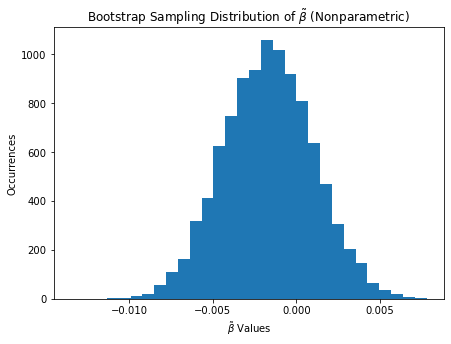

In [49]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30)
plt.xlabel("$\\tilde{\\beta}$ Values")
plt.ylabel("Occurrences")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\beta}$ (Nonparametric)");
plt.show()

In [50]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(-0.006914368065320342, 0.0035962592902859126)

In [60]:
def T_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['group']})
    theta_T = results.params[1]

    return theta_T

data_array = good_data.loc[:, ["inv_appchg", "T", "group", "pop", 'time']].values

theta_hat_sampling = bootstrap(data_array, T_coeff)

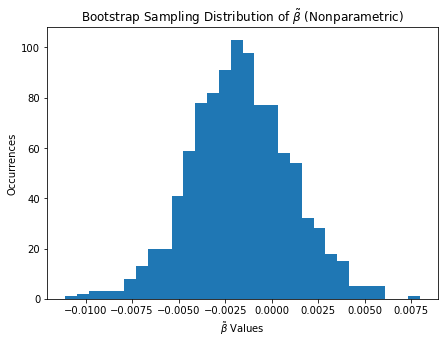

In [61]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30)
plt.xlabel("$\\tilde{\\beta}$ Values")
plt.ylabel("Occurrences")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\beta}$ (Nonparametric)");
plt.show()

In [62]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(-0.006917098685915454, 0.003730217795864662)

# Start analysis on firms and universities
## Much of the code here follows what was done before and so there are less annotations.

In [63]:
gc.collect()

26981

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from unidecode import unidecode
from cleanco import cleanco
import regex


# Load in firm based data. master.csv was created outside of thsi code and is a dataframe containing all patent transactions. From this dataframe we are able to extract all of the firms who have patents assigned to them by their inventors. This is done using the 'employer_assign' variable which indicates if a patent is being assigned to a company by one of their employees. We are now looking only at granted patents. 
def launching():
    df = pd.read_csv(r'C:\Users\sambo\Desktop\615\assignee.csv', dtype=str, usecols = ['rf_id','ee_state'])
    master = pd.read_csv(r'C:\Users\sambo\Desktop\615\master.csv', dtype = str, usecols=['rf_id','assignee_name','assignor_name','application_id','application_date', 'patent_kind','convey_text' ] )
    conveyance = pd.read_csv(r'C:\Users\sambo\Desktop\615\assignment_conveyance.csv', dtype=str)
    conveyance.drop_duplicates(subset='rf_id', keep='first', inplace= True, ignore_index=True)
    master = master[master['patent_kind'].isin(['B', 'B1', 'B2', 'A'])]
    master = pd.merge(master, conveyance, on='rf_id', how ='left')
    master = pd.merge(master, df, on='rf_id', how ='left')
    master = master[master['employer_assign'] == '1']
    master['application_number'] = master['application_id']
    master['filing_date'] = master['application_date']
    master.dropna(subset=['ee_state'] ,inplace=True)
    return master
                     


# %%
df = launching()


# %%
del df['application_id']
del df['application_date']


# %%
df.sort_values(by='filing_date', inplace=True, ignore_index=True)


# %%
df['filing_year'] = df['filing_date'].str[:4]
df.dropna(subset=['filing_year'] ,inplace=True)
df['filing_year'] = df['filing_year'].astype(int)


# %%
ny = df[df['ee_state'].str.contains("NEW YORK")]

tx = df[df['ee_state'].str.contains("TEXAS")]


# %%
del df


# %%



# %%
both = pd.concat([ny, tx])


# %%
SUFFIX_PATH = r'C:\Users\sambo\Desktop\615\suffixlookup.csv'
FUZZY_PATH = r'C:\Users\sambo\Desktop\615\fuzzylookup.csv'


#Standardize the company name string to the most basic format. Use the cleanco package as well as premade lists to remove company suffixes.
def standardize(ser):
    ser = ser.apply(unidecode)
    ser = ser.str.lower()
    ser = ser.str.replace('&','and')
    ser = ser.str.replace(',',' ')
    ser = ser.str.replace('[^0-9a-zA-Z .]','')
    ser = ser.str.replace(' {2,}',' ')
    ser = ser.str.strip()

    suffixlookup = pd.read_csv(SUFFIX_PATH)
    fuzzylookup = pd.read_csv(FUZZY_PATH)
    fuzzylookup['error'] = fuzzylookup['error'].astype(str)

    #Direct replacements
    for x in suffixlookup.index:
        row = suffixlookup.iloc[x]
        ser = ser.str.replace(row['key'],row['val'])

    #Fuzzy replacements, to catch misspellings
    def fuzzy_sub(org,key,val,error):
        return regex.sub(regex.compile('(^| )('+key+'){e<='+error+'}($| )'),r'\1'+val+r'\3',org)
    for x in fuzzylookup.index:
        row = fuzzylookup.iloc[x]
        ser = ser.apply(fuzzy_sub,args=(row['key'],row['val'],row['error']))

    #Further standardization using cleanco

    ser = ser.apply(lambda x: cleanco(cleanco(x).clean_name()).clean_name())
    ser = ser.str.replace('[.]','')

    return ser


# %%
both = both[(both['filing_year'] >= 2008)]


# %%
both['assignee_disambig'] = standardize(both['assignee_name'])

In [65]:
# Dropping stop words commonly involved with universities
both['assignee_disambig'] = both['assignee_disambig'].str.replace('the', '').str.replace('of', '').str.replace('regents', '').str.replace('board', '').str.replace('trustees', '')

In [66]:
ny = both[both['ee_state'].str.contains("NEW YORK")]
tx = both[both['ee_state'].str.contains("TEXAS")]

In [67]:
ny.drop_duplicates(subset=['application_number','assignee_disambig'], inplace=True)
tx.drop_duplicates(subset=['application_number','assignee_disambig'], inplace=True)

In [68]:
# Count the the total number of applications filed by all inventors in both states for each year.
ny_year_count = ny.groupby(['filing_year', 'ee_state'], as_index=False).agg({'application_number': 'count'})
tx_year_count = tx.groupby(['filing_year', 'ee_state'], as_index= False).agg({'application_number': 'count'})

In [69]:
# Count the number of applications filed by each firm in both states for each year.
ny_year_comp_count = ny.groupby(['assignee_disambig','filing_year'], as_index=False).agg({'application_number': 'count'})
tx_year_comp_count = tx.groupby(['assignee_disambig','filing_year'], as_index= False).agg({'application_number': 'count'})

In [70]:
# Ensuring that every firm has an entry for every year even if they did not file any patent applications in that year.
mux_tx = pd.MultiIndex.from_product([
        tx.assignee_disambig.unique(),
        range(tx.filing_year.min(), tx.filing_year.max() + 1)
    ], names=['assignee_disambig', 'filing_year'])
mux_ny = pd.MultiIndex.from_product([
        ny.assignee_disambig.unique(),
        range(ny.filing_year.min(), ny.filing_year.max() + 1)
    ], names=['assignee_disambig', 'filing_year'])

ny.drop_duplicates(subset=['assignee_disambig', 'filing_year'], inplace=True) 
tx.drop_duplicates(subset=['assignee_disambig', 'filing_year'], inplace=True)


ny = ny.set_index(['assignee_disambig', 'filing_year']).reindex(mux_ny).reset_index()
tx = tx.set_index(['assignee_disambig', 'filing_year']).reindex(mux_tx).reset_index()


In [71]:
# Merge these new counts on to state dataframes
ny = ny.merge(ny_year_count, on='filing_year', how='left')
tx = tx.merge(tx_year_count, on='filing_year', how='left')
ny = ny.merge(ny_year_comp_count, on=['assignee_disambig','filing_year'], how='left')
tx = tx.merge(tx_year_comp_count, on=['assignee_disambig','filing_year'], how='left')


In [72]:
ny['comp_patent_count'] = ny['application_number']
tx['comp_patent_count'] = tx['application_number']
ny['state_patent_count'] = ny['application_number_y']
tx['state_patent_count'] = tx['application_number_y']
ny['ee_state'] = ny['ee_state_x']
tx['ee_state'] = tx['ee_state_x']

In [73]:
# Fill in the missing data
ny['ee_state'] = ny['ee_state'].fillna('NEW YORK')
tx['ee_state'] = tx['ee_state'].fillna('TEXAS')
ny['comp_patent_count'] = ny['comp_patent_count'].fillna(0)
tx['comp_patent_count'] = tx['comp_patent_count'].fillna(0)

In [74]:
# Only taking the columns necessary for analysis
ny = ny[[ 'assignee_disambig', 'ee_state' ,'filing_year' , 'state_patent_count','comp_patent_count']]
tx = tx[[ 'assignee_disambig', 'ee_state' ,'filing_year' , 'state_patent_count','comp_patent_count']]

In [75]:
# Creating our dependent variable. This variable is called 'inv_app' change and it looks at the difference in the number of patent applications filed between the current period and the previous period. This tells us if an inventor is producing more, less, or the same amount of patent applications year over year. 
ny = ny.sort_values(['assignee_disambig', 'filing_year']).reset_index(drop=True)
ny['comp_patdiff'] = ny.groupby('assignee_disambig', sort=False)['comp_patent_count'].apply(
     lambda x: x.diff()).to_numpy()
tx = tx.sort_values(['assignee_disambig', 'filing_year']).reset_index(drop=True)
tx['comp_patdiff'] = tx.groupby('assignee_disambig', sort=False)['comp_patent_count'].apply(
     lambda x: x.diff()).to_numpy()


In [76]:
# Creating a dependent variable that is the percent change in inventors filing patents in New York or Texas for each year.
ny_years = ny.drop_duplicates(subset='filing_year') 
tx_years = tx.drop_duplicates(subset='filing_year') 
ny_years['state_patchg'] = ny_years['state_patent_count'].pct_change()
tx_years['state_patchg'] = tx_years['state_patent_count'].pct_change()
ny_years = ny_years[['state_patchg', 'filing_year']]
tx_years = tx_years[['state_patchg', 'filing_year']]

<AxesSubplot:xlabel='filing_year'>

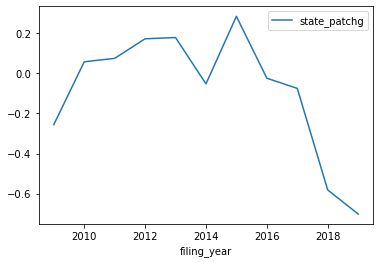

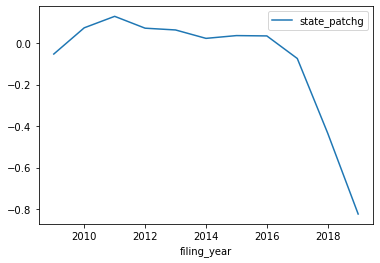

In [77]:
# Graphing the percent change in inventors filing patents in New York or Texas for each year.
ny_years.plot('filing_year','state_patchg')
tx_years.plot('filing_year','state_patchg')

In [78]:
# Merging the state application change variable on to the state dataframes.
ny = ny.merge(ny_years, how='left', on='filing_year')
tx = tx.merge(tx_years, how='left', on='filing_year')

In [79]:
# Add the dummy variables in for rows that were created and are missing them.
# Also adding in the population as a control variable 
ny_0 = ny[(ny['filing_year'] > 2008) & (ny['filing_year'] < 2014)]
ny_1 = ny[(ny['filing_year'] >= 2014) & (ny['filing_year'] < 2020)]
tx_0 = tx[(tx['filing_year'] > 2008) & (tx['filing_year'] < 2014)]
tx_1 = tx[(tx['filing_year'] >= 2014) & (tx['filing_year'] < 2020)]
ny_0['T'] = 0
ny_1['T'] = 1
tx_0['T'] = 0
tx_1['T'] = 0
ny_0['time'] = 0
ny_1['time'] = 1
tx_0['time'] = 0
tx_1['time'] = 1
ny_0['group'] = 1
ny_1['group'] = 1
tx_0['group'] = 0
tx_1['group'] = 0
good_ny= pd.concat([ny_0, ny_1])
good_tx= pd.concat([tx_0, tx_1])

pop = pd.read_excel(r'C:\Users\sambo\Desktop\615\nytxdid.xls', sheet_name='Annual')
pop['filing_year'] = pop['DATE'].astype(str).str[:4]
pop['filing_year'] = pop['filing_year'].astype(int)
pop['ny_pop'] = pop['NYPOP']* 1000
pop['tx_pop'] = pop['TXPOP']* 1000 
del pop['NYPOP']
del pop['TXPOP']
del pop['DATE']

good_ny = pd.merge(good_ny, pop, how='left', on = 'filing_year')
good_tx = pd.merge(good_tx, pop, how='left', on = 'filing_year')

good_ny['pop'] = good_ny['ny_pop'] 
good_tx['pop'] = good_tx['tx_pop'] 
del good_ny['ny_pop'] 
del good_ny['tx_pop'] 
del good_tx['tx_pop'] 
del good_tx['ny_pop'] 

good_data = pd.concat([good_ny, good_tx])


In [80]:
# Preparing data for analysis at state level.
# Creating dummy variables for each year

good_data = good_data[good_data.assignee_disambig != '']
good_data.drop_duplicates(subset=['filing_year','ee_state','state_patchg'], inplace=True)
good_data.reset_index(drop= True, inplace=True)
yeardummy = pd.get_dummies(good_data['filing_year'])
good_data= pd.concat([good_data, yeardummy], axis=1)

In [81]:
good_data['y'] = good_data['state_patchg']
y = good_data['y']
X = good_data[['T','group','pop',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]
X = sm.add_constant(X)

model = sm.OLS(y, X)
results5 = model.fit()
print(results5.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.955
Model:                            OLS   Adj. R-squared:                  0.883
Method:                 Least Squares   F-statistic:                     13.16
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           0.000535
Time:                        08:39:21   Log-Likelihood:                 30.484
No. Observations:                  22   AIC:                            -32.97
Df Residuals:                       8   BIC:                            -17.69
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.1299      1.674      0.675      0.5

In [82]:
good_data['y'] = good_data['state_patchg']
y = good_data['y']
X = good_data[['T','group','pop','time']]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results6 = model.fit()
print(results6.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.089
Method:                 Least Squares   F-statistic:                     1.516
Date:                Mon, 21 Dec 2020   Prob (F-statistic):              0.242
Time:                        08:39:21   Log-Likelihood:               -0.35218
No. Observations:                  22   AIC:                             10.70
Df Residuals:                      17   BIC:                             16.16
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3569      3.317      1.313      0.2

In [83]:
# Preparing data for analysis at firm level 
good_data = pd.concat([good_ny, good_tx])
good_data = good_data.dropna(subset=['assignee_disambig'])
good_data = good_data[good_data.assignee_disambig != '']
good_data.reset_index(drop= True, inplace=True)
yeardummy = pd.get_dummies(good_data['filing_year'])
good_data= pd.concat([good_data, yeardummy], axis=1)

In [84]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates

In [85]:
def T_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['group']})
    Beta_T = results.params[1]

    return Beta_T

data_array = good_data.loc[:, ["state_patchg", "T", "group",'pop',"time"]].values

theta_hat_sampling = bootstrap(data_array, T_coeff)

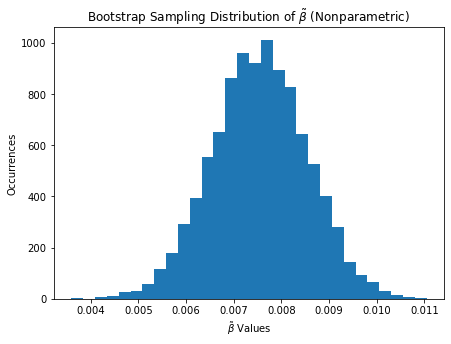

In [86]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30)
plt.xlabel("$\\tilde{\\beta}$ Values")
plt.ylabel("Occurrences")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\beta}$ (Nonparametric)");
plt.show()

In [87]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(0.005586662022953172, 0.009480825584622831)

In [88]:
good_data['y'] = good_data['comp_patdiff']
y = good_data['y']
X = good_data[['T','group','pop',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results7 = model.fit()
print(results7.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.910
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           0.000307
Time:                        08:48:25   Log-Likelihood:            -5.7737e+05
No. Observations:              128656   AIC:                         1.155e+06
Df Residuals:                  128642   BIC:                         1.155e+06
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9332      4.702     -0.411      0.6

In [89]:
model = sm.OLS(y, X)
results8 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
print(results8.summary())


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     5.619
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.04e-09
Time:                        08:48:27   Log-Likelihood:            -5.7737e+05
No. Observations:              128656   AIC:                         1.155e+06
Df Residuals:                  128642   BIC:                         1.155e+06
Df Model:                          13                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.9332      4.132     -0.468      0.6

In [90]:
good_data['y'] = good_data['comp_patdiff']
y = good_data['y']
X = good_data[['T','group','pop','time']]
X = sm.add_constant(X)
model = sm.OLS(y, X)
results9 = model.fit()
print(results9.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     2.064
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0827
Time:                        08:48:27   Log-Likelihood:            -5.7739e+05
No. Observations:              128656   AIC:                         1.155e+06
Df Residuals:                  128651   BIC:                         1.155e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2697      3.219      1.016      0.3

In [91]:
model = sm.OLS(y, X)
results10 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
print(results10.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     9.500
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           2.90e-06
Time:                        08:48:28   Log-Likelihood:            -5.7739e+05
No. Observations:              128656   AIC:                         1.155e+06
Df Residuals:                  128651   BIC:                         1.155e+06
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.2697      1.789      1.828      0.0

In [92]:
# Preparing data for analysis at university level 
good_data = pd.concat([good_ny, good_tx])
good_data = good_data.dropna(subset=['assignee_disambig'])
good_data = good_data[good_data.assignee_disambig != '']
good_data.reset_index(drop= True, inplace=True)
yeardummy = pd.get_dummies(good_data['filing_year'])
good_data= pd.concat([good_data, yeardummy], axis=1)
good_data= good_data[good_data['assignee_disambig'].str.contains("university | college", case=False)]

In [93]:
good_data['y'] = good_data['comp_patdiff']
y = good_data['y']
X = good_data[['T','group','pop',2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]]
X = sm.add_constant(X)

In [94]:
model = sm.OLS(y, X)
results11 = model.fit()
print(results11.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     3.607
Date:                Mon, 21 Dec 2020   Prob (F-statistic):           1.20e-05
Time:                        08:48:29   Log-Likelihood:                -4706.5
No. Observations:                1837   AIC:                             9441.
Df Residuals:                    1823   BIC:                             9518.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8817      5.803      0.497      0.6

In [95]:
model = sm.OLS(y, X)
results12= model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
print(results12.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.018
Method:                 Least Squares   F-statistic:                     1.243
Date:                Mon, 21 Dec 2020   Prob (F-statistic):              0.258
Time:                        08:48:30   Log-Likelihood:                -4706.5
No. Observations:                1837   AIC:                             9441.
Df Residuals:                    1823   BIC:                             9518.
Df Model:                          13                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.8817      9.026      0.319      0.7

In [96]:
good_data['y'] = good_data['comp_patdiff']
y = good_data['y']
X = good_data[['T','group','pop','time']]
X = sm.add_constant(X)

In [97]:
model = sm.OLS(y, X)
results13 = model.fit()
print(results13.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.681
Date:                Mon, 21 Dec 2020   Prob (F-statistic):            0.00543
Time:                        08:48:31   Log-Likelihood:                -4722.5
No. Observations:                1837   AIC:                             9455.
Df Residuals:                    1832   BIC:                             9483.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6419      4.384      2.199      0.0

In [98]:
model = sm.OLS(y, X)
results14 = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
print(results14.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     3.286
Date:                Mon, 21 Dec 2020   Prob (F-statistic):             0.0223
Time:                        08:48:31   Log-Likelihood:                -4722.5
No. Observations:                1837   AIC:                             9455.
Df Residuals:                    1832   BIC:                             9483.
Df Model:                           4                                         
Covariance Type:              cluster                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.6419      6.895      1.398      0.1

In [99]:
def simple_resample(n): 
    return(np.random.randint(low = 0, high = n, size = n))

def bootstrap(boot_pop, statistic, resample = simple_resample, replicates = 10000):
    n = len(boot_pop)
    resample_estimates = np.array([statistic(boot_pop[resample(n)]) for _ in range(replicates)])
    return resample_estimates


In [100]:
def T_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
    Beta_T = results.params[1]

    return Beta_T

data_array = good_data.loc[:, ["comp_patdiff", "T", "group",'pop',"time"]].values

theta_hat_sampling = bootstrap(data_array, T_coeff)

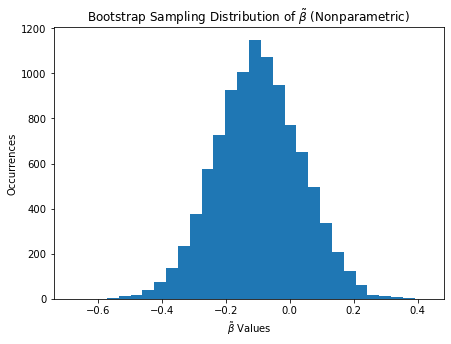

In [101]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30)
plt.xlabel("$\\tilde{\\beta}$ Values")
plt.ylabel("Occurrences")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\beta}$ (Nonparametric)");
plt.show()


In [102]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(-0.3566829359828023, 0.16386719224149596)

In [103]:
def T_coeff(data_array):
    X = data_array[:, 1:]
    y = data_array[:, 0]
    model = sm.OLS(y, X)
    results = model.fit(cov_type='cluster', cov_kwds={'groups': good_data['assignee_disambig']})
    Beta_T = results.params[1]

    return Beta_T

data_array = good_data.loc[:, ["comp_patdiff", "T", "group",'pop',"time"]].values

theta_hat_sampling = bootstrap(data_array, T_coeff)

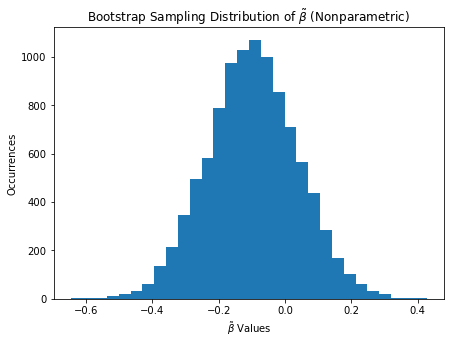

In [104]:
plt.figure(figsize = (7, 5))
plt.hist(theta_hat_sampling, bins = 30)
plt.xlabel("$\\tilde{\\beta}$ Values")
plt.ylabel("Occurrences")
plt.title("Bootstrap Sampling Distribution of $\\tilde{\\beta}$ (Nonparametric)");
plt.show()

In [105]:
left_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 2.5)
right_confidence_interval_endpoint = np.percentile(theta_hat_sampling, 97.5)

left_confidence_interval_endpoint, right_confidence_interval_endpoint

(-0.362059954386346, 0.17084547228699107)

In [106]:
dfoutputgroups = summary_col([results3,results4,results7,results8,results9,results10,results11,results12,results13,results14],stars=True)

In [107]:
dfoutputstates = summary_col([results1,results5,results2,results6],stars=True)

In [108]:
print(dfoutputgroups)


                  y I        y II     y III    y IIII  y IIIII   y IIIIII  y IIIIIII y IIIIIIII y IIIIIIIII y IIIIIIIIII
------------------------------------------------------------------------------------------------------------------------
T              -0.0125    0.0036     0.0270   0.0270   -0.4127  -0.4127*** 0.1036    0.1036     -0.4821     -0.4821     
               (0.0084)   (0.0059)   (0.4917) (0.1511) (0.3753) (0.1359)   (0.6051)  (0.6046)   (0.4924)    (0.4485)    
const          0.1960**   0.0974**   -1.9332  -1.9332  3.2697   3.2697*    2.8817    2.8817     9.6419**    9.6419      
               (0.0774)   (0.0494)   (4.7025) (4.1320) (3.2189) (1.7885)   (5.8033)  (9.0259)   (4.3844)    (6.8954)    
group          -0.0687*** -0.0252**  0.4166   0.4166   -0.7687  -0.7687    -0.8484   -0.8484    -2.4269**   -2.4269     
               (0.0188)   (0.0119)   (1.1679) (1.0112) (0.7941) (0.4733)   (1.4373)  (2.2549)   (1.0768)    (1.7101)    
pop            -0.0000*** -0.00